In [18]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook as tqdm
import json
import copy
import mmcv
from multiprocessing import Pool
import sys
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
import random
from PIL import Image
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)
CLASS=['tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad']
#CLASS={'tennis-court', 'container-crane', 'storage-tank', 'baseball-diamond', 'plane', 'ground-track-field', 'helicopter', 'airport', 'harbor', 'ship', 'large-vehicle', 'swimming-pool', 'soccer-ball-field', 'roundabout', 'basketball-court', 'bridge', 'small-vehicle', 'helipad'}
class_to_ind = dict(zip(CLASS, range(len(CLASS))))
print(class_to_ind)

{'tennis-court': 0, 'container-crane': 1, 'storage-tank': 2, 'baseball-diamond': 3, 'plane': 4, 'ground-track-field': 5, 'helicopter': 6, 'airport': 7, 'harbor': 8, 'ship': 9, 'large-vehicle': 10, 'swimming-pool': 11, 'soccer-ball-field': 12, 'roundabout': 13, 'basketball-court': 14, 'bridge': 15, 'small-vehicle': 16, 'helipad': 17}


In [19]:
def bbox_overlaps_py(boxes, query_boxes):
    """
    determine overlaps between boxes and query_boxes
    :param boxes: n * 4 bounding boxes
    :param query_boxes: k * 4 bounding boxes
    :return: overlaps: n * k overlaps
    """
    n_ = boxes.shape[0]
    k_ = query_boxes.shape[0]
    overlaps = np.zeros((n_, k_), dtype=np.float)
    for k in range(k_):
        query_box_area = (query_boxes[k, 2] - query_boxes[k, 0] + 1) * (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        for n in range(n_):
            iw = min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1
            if iw > 0:
                ih = min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1
                if ih > 0:
                    box_area = (boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1)
                    all_area = float(query_box_area)
                    overlaps[n, k] = iw * ih / all_area
    return overlaps

def _pygenerate(boxes, masks, labels, width, height, chipsize, stride):
        chips = []
        boxes = np.array(boxes)
        masks = np.array(masks)
        # ensure coverage of image for worst case
        # corners
        chips.append([max(width - chipsize, 0), 0, width - 1, min(chipsize, height-1)])
        chips.append([0, max(height - chipsize, 0), min(chipsize, width-1), height-1])
        chips.append([max(width - chipsize, 0), max(height - chipsize, 0), width-1, height-1])
		
        for i in range(0, width - int(chipsize), stride):
            for j in range(0, height - int(chipsize), stride):
                x1 = i
                y1 = j
                x2 = i + chipsize - 1
                y2 = j + chipsize - 1
                chips.append([x1, y1, x2, y2])
		#width may not be divide by stride
        for j in range(0, height - int(chipsize), stride):
            x1 = max(width - chipsize - 1,0)
            y1 = j
            x2 = width - 1
            y2 = j + chipsize - 1
            chips.append([x1, y1, x2, y2])
		#the same as above
        for i in range(0, width - int(chipsize), stride):
            x1 = i
            y1 = max(height - chipsize - 1,0)
            x2 = i + chipsize - 1
            y2 = height - 1
            chips.append([x1, y1, x2, y2])

        chips = np.array(chips).astype(np.float)
        overlaps = bbox_overlaps_py(chips, boxes.astype(np.float))
        fchips = []
        masks_list = []
        boxes_list = []
        labels_list = []
        for j in range(len(chips)):
            nvids = np.where(overlaps[j, :] >= 0.9)[0]
            if(len(nvids) == 0):
                continue
            else:
                fchips.append(chips[j])
                boxes_list.append(boxes[nvids])
                masks_list.append(masks[nvids])
                labels_list.append([labels[x] for x in nvids])
        return fchips, masks_list, boxes_list, labels_list
# from split.split import _pygenerate
def get_scale_info(fp, scale):
    masks = []
    labels = []
    boxes = []
    for line in fp:
        line = line.strip()
        if not line:
            continue
        items = line.split(' ')
        loc = np.array([float(x) for x in items[:8]])
        loc = loc*scale
        xs = loc[0::2]
        ys = loc[1::2]
        poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
        area = cv2.contourArea(poly)
        if(area < 50):
            continue
        xmin  = min(xs)
        xmax = max(xs)
        ymin = min(ys)
        ymax = max(ys)
        w = xmax - xmin
        h = ymax - ymin
        cls = items[8]
        if cls not in CLASS:
            continue
        labels.append(cls)
        masks.append(loc)
        boxes.append([xmin,ymin,xmax,ymax])
    return labels, masks, boxes
def construct_imginfo(filename, h, w, ID):
    image = { "license": 1,
              "file_name": filename,
              "coco_url": "xxx",
              "height": h,
              "width": w,
              "date_captured": "2019-06-25",
              "flickr_url": "xxx",
              "id": ID
            }
    return image

def construct_ann(obj_id, ID, category_id, seg, area, bbox):
    ann = {"id" : obj_id, 
                "image_id" : ID, 
                "category_id" : category_id, 
                "segmentation" : seg, 
               "area" :  area, 
               "bbox" : bbox, 
               "iscrowd" : 0,
            }
    return ann

def generate_ann(box, mask, label, xmin, ymin):
    ann = []
    for b, loc, l in zip(box, mask, label):
        x1, y1, x2, y2 = b
        x1 -= xmin
        y1 -= ymin
        x2 -= xmin
        y2 -= ymin
        poly = np.array([[[loc[0],loc[1]],[loc[2],loc[3]],[loc[4],loc[5]],[loc[6], loc[7]]]], np.int32)
        box = [x1, y1, x2, y2]
        area = cv2.contourArea(poly)
        poly = [loc[0]-xmin,loc[1]-ymin,loc[2]-xmin,loc[3]-ymin,loc[4]-xmin,loc[5]-ymin,loc[6]-xmin, loc[7]-ymin]
        obj = [class_to_ind[l], [poly], area, [x1, y1, x2-x1, y2-y1]]
        ann.append(obj)
    return ann
   
from icecream import ic
import time
def scale_genrate_warpper(label_path, img_name, img_path, outdir, phase, SCALE):
    annotation = []
    original_img = cv2.imread(img_path)
    scales = copy.deepcopy(SCALE)
    fp = open(label_path).readlines()[2:]
    for scale in scales:
        img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
        H,W,_ = img.shape
        labels, masks, boxes = get_scale_info(fp, scale_factor)
        if(len(labels)<=0):
            continue
        if max(H,W) > 512:
            fchips, masks, boxes, labels = _pygenerate(boxes, masks, labels, W, H, 512, 416)
            count = 0
            for chip, mask, box, label in zip(fchips, masks, boxes,labels):
                count+=1
                xmin, ymin, xmax, ymax = chip
                filename = img_name.split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(xmin), str(ymin), str(0))+"part" +str(count) + ".jpg"
                img2 = copy.deepcopy(img[int(ymin):int(ymax), int(xmin):int(xmax),:])
                h, w, _ = img2.shape
                cv2.imwrite("{}/{}/".format(outdir, phase)+filename, img2)
                image = [filename, h ,w]
                anns = generate_ann(box, mask, label, xmin, ymin)
                annotation.append({"image":image, "anns":anns})
                
        else:
            filename = img_name.split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(0))+"part" +str(0) + ".jpg"
            image = [filename, H, W]
            cv2.imwrite("{}/{}/".format(outdir, phase)+filename, img)
            anns = generate_ann(boxes, masks, labels, 0, 0)
            annotation.append({"image":image, "anns":anns})
    return annotation

def scale_generate(datdir, labeldir, phase, outdir, SCALE):
    imgs = os.listdir(datadir)
    info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)
    print(categories)
    annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
    p = Pool(4)
    rets = []
    pbar = tqdm(total=len(imgs))
    def update(*a):
        pbar.update()
    for img_id in range(len(imgs)):
        img_path = os.path.join(datadir, imgs[img_id])
        label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
        rets.append(p.apply_async(scale_genrate_warpper, args=(label_path, imgs[img_id], img_path, outdir, phase, SCALE), callback=update))
    obj_id = 0
    ID = 0
    for ret in rets:
        result = ret.get()
        for info in result:
            filename, h, w = info["image"]  
            anns = info["anns"]
            image = construct_imginfo(filename, h, w, ID)
            annotations["images"].append(image)
            for ann in anns:
                category_id, seg, area, bbox = ann
                ann_info = construct_ann(obj_id, ID, category_id, seg, area, bbox)
                annotations["annotations"].append(ann_info)
                obj_id += 1
            ID += 1 
    with open('{}/annotation/annos_rscup_'.format(outdir)+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))

def increment_warpper_train(img_path, img_name, label_path, outdir, phase):
    original_img = cv2.imread(img_path)
    h, w, _ = original_img.shape
    if(max(h,w)/min(h,w)>5):
        return None
    scale = 512 /  max(h, w)
    fp = open(label_path).readlines()[2:]
    img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
    H,W,_ = img.shape
    labels, masks, boxes = get_scale_info(fp, scale_factor)
    filename = img_name.split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(0))+"part" +"xx" + ".jpg"
    image = [filename, H, W]
    cv2.imwrite("{}/{}/".format(outdir, phase)+filename, img)
    anns = generate_ann(boxes, masks, labels, 0, 0)
    return {"image":image, "anns":anns}

def increment_train_generate(datadir, labeldir, json_file, outdir,  phase):
    imgs = os.listdir(datadir)
    coco=COCO(json_file)
    annotations = mmcv.load(json_file)
    imgids = coco.getImgIds()
    annids = coco.getAnnIds()
    ID = max(imgids)+1
    obj_id = max(annids)+1
    rets = []
    pbar = tqdm(total=len(imgs))
    p=Pool(4)
    def update(*a):
        pbar.update()
    for img_id in tqdm(range(len(imgs))):
        img_path = os.path.join(datadir, imgs[img_id])
        label_path = os.path.join(labeldir, imgs[img_id].split(".")[0]+".txt")
        rets.append(p.apply_async(increment_warpper_train, args=(img_path, imgs[img_id], label_path, outdir, phase), callback=update))
    for ret in rets:
        info = ret.get()
        if info is None:
            continue
        filename, h, w = info["image"]
        image =  construct_imginfo(filename, h, w, ID)
        annotations["images"].append(image)
        anns = info["anns"]
        for ann in anns:
            category_id, seg, area, bbox = ann
            ann_info = construct_ann(obj_id, ID, category_id, seg, area, bbox)
            annotations["annotations"].append(ann_info)
            obj_id += 1
        ID += 1 
    with open(json_file, 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))
    p.close()
    p.join()
    
    

#################################### TEST ######################################

    
    
    
    
def test_pygenerate(width, height, chipsize, stride):
        chips = []
        # ensure coverage of image for worst case
        # corners
        chips.append([max(width - chipsize, 0), 0, width - 1, min(chipsize, height-1)])
        chips.append([0, max(height - chipsize, 0), min(chipsize, width-1), height-1])
        chips.append([max(width - chipsize, 0), max(height - chipsize, 0), width-1, height-1])
		
        for i in range(0, width - int(chipsize), stride):
            for j in range(0, height - int(chipsize), stride):
                x1 = i
                y1 = j
                x2 = i + chipsize - 1
                y2 = j + chipsize - 1
                chips.append([x1, y1, x2, y2])
		#width may not be divide by stride
        for j in range(0, height - int(chipsize), stride):
            x1 = max(width - chipsize - 1,0)
            y1 = j
            x2 = width - 1
            y2 = j + chipsize - 1
            chips.append([x1, y1, x2, y2])
		#the same as above
        for i in range(0, width - int(chipsize), stride):
            x1 = i
            y1 = max(height - chipsize - 1,0)
            x2 = i + chipsize - 1
            y2 = height - 1
            chips.append([x1, y1, x2, y2])

        chips = np.array(chips).astype(np.float)
        return chips
def test_generater(imgname, img_path, outdir, phase, SCALE):
    annotation = []
    original_img = cv2.imread(img_path)
    scales = copy.deepcopy(SCALE)
    for scale in scales:
        img, scale_factor = mmcv.imrescale(original_img, scale, return_scale=True)
        H,W,_ = img.shape
        if max(H,W) > 512:
            fchips = test_pygenerate(W, H, 512, 416)
            count = 0
            for chip in  fchips:
                count+=1
                xmin, ymin, xmax, ymax = chip
                img2 = copy.deepcopy(img[int(ymin):int(ymax), int(xmin):int(xmax),:])
                h, w, _ = img2.shape
                filename = imgname.split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(xmin), str(ymin), str(0))+"part" +str(count) + ".jpg"
                cv2.imwrite("{}/{}/".format(outdir, phase)+filename, img2)
                image = [filename, h ,w]
                annotation.append(image)
        else:
            filename = imgname.split(".")[0] + "_{}_{}_{}_{}".format(str(scale), str(0), str(0), str(0))+"part" +str(0) + ".jpg"
            image = [filename, H ,W]
            annotation.append(image)
            cv2.imwrite("{}/{}/".format(outdir, phase)+filename, img)
    return annotation
            
def scale_generate_test(datdir, outdir, phase, SCALE):
    imgs = os.listdir(datadir)
    info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
    license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"} ]
    categories = []
    for cls in CLASS:
        category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
        categories.append(category)
    print(categories)
    annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
    obj_id = 0
    ID = 0
    p = Pool(4)
    rets = []
    pbar = tqdm(total=len(imgs))
    def update(*a):
        pbar.update()
    for img_id in range(len(imgs)):
        img_path = os.path.join(datadir, imgs[img_id])
        rets.append(p.apply_async(test_generater, args=(imgs[img_id], img_path, outdir, phase, SCALE), callback=update))
    for ret in rets:
        result = ret.get()
        for info in result:
            filename, h, w = info 
            image = construct_imginfo(filename, h, w, ID)
            annotations["images"].append(image)
            ID += 1 
                
    with open('{}/annotation/annos_rscup_'.format(outdir)+phase+'.json', 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))
    p.close()
    p.join()


def increment_warpper(img_path, img_name, outdir, phase):
    original_img = cv2.imread(img_path)
    h, w, _ = original_img.shape
    if(max(h, w)/min(h,w) > 5):
        return None
    scale_factor = 512 /  max(h, w)
    img, scale_factor = mmcv.imrescale(original_img, scale_factor, return_scale=True)
    H,W,_ = img.shape
    filename = img_name.split(".")[0] + "_{}_{}_{}_{}".format(str(scale_factor), str(0), str(0), str(0))+"part" +"xx" + ".jpg"
    cv2.imwrite("{}/{}/".format(outdir, phase)+filename, img)
    return [filename, H, W]

def increment_generate(datdir, json_file, outdir, phase):
    imgs = os.listdir(datadir)
    coco=COCO(json_file)
    annotations = mmcv.load(json_file)
    imgids = coco.getImgIds()
    ID = max(imgids)+1
    rets = []
    pbar = tqdm(total=len(imgs))
    p=Pool(4)
    def update(*a):
        pbar.update()
    for img_id in range(len(imgs)):
        img_path = os.path.join(datadir, imgs[img_id])
        rets.append(p.apply_async(increment_warpper, args=(img_path, imgs[img_id], outdir, phase), callback=update))
    for ret in rets:
        info = ret.get()
        if(info is None):
            continue
        filename, h, w = info 
        image = construct_imginfo(filename, h, w, ID)
        annotations["images"].append(image)
        ID+=1
    with open(json_file, 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)
    print("totol number {}".format(str(ID)))   
    p.close()
    p.join()
    

## train

In [20]:
datadir = "/home/xfr/rssid/data/train/images"
labeldir = "/home/xfr/rssid/data/train/labelTxt"
scale_generate(datadir, labeldir, "train","./data/trash", [2])
increment_train_generate(datadir, labeldir, "./data/trash/annotation/annos_rscup_s2.json", "./data/trash", "train")

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 53490
loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: './data/trash/annotation/annos_rscup_s2.json'

## test

In [21]:
datadir = "/home/xfr/rssid/data/test/images"
scale_generate_test(datadir, "./data/rscup", "test", [0.5, 1, 2])
increment_generate(datadir, "./data/rscup/annotation/annos_rscup_test.json", "./data/rscup", "test")

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 258617
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


totol number 259397


## val

In [148]:
datadir = "/home/xfr/rssid/data/val/images"
scale_generate_test(datadir, "./data/rscup", "val", [0.5, 1])
increment_generate(datadir, "./data/rscup/annotation/annos_rscup_val.json", "./data/rscup", "val")

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 36909
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


totol number 37499


### pesudo data

In [12]:
datadir = "./result/pesudo/images"
labeldir = "./result/pesudo/labelTxt"
scale_generate(datadir, labeldir, "pesudo","./data/trash/", [0.5, 1])
increment_train_generate(datadir, labeldir, "./data/trash/annotation/annos_rscup_pesudo.json", "./data/trash", "pesudo")

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

totol number 22510
loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


totol number 23290


### Debug

In [183]:
info = {
        "description": "rscup",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2014,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
      }
license = [{ "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"}]
categories = []
for cls in CLASS:
    category = { "id" : class_to_ind[cls], "name" : cls, "supercategory" : "object",}
    categories.append(category)
print(categories)
annotations = {"info": info, "images": [], "annotations": [], "categories":categories, "license":license}
img1 = cv2.imread("./data/rscup/debug/1.jpg")
filename = "1.jpg"
h,w,_ = img1.shape
image =  construct_imginfo(filename, h, w, 0)
annotations["images"].append(image)
img2 = cv2.imread("./data/rscup/debug/2.jpg")
filename = "2.jpg"
h,w,_ = img2.shape
image =  construct_imginfo(filename, h, w, 1)
annotations["images"].append(image)
img2 = cv2.imread("./data/rscup/debug/3.jpg")
filename = "3.jpg"
h,w,_ = img2.shape
image =  construct_imginfo(filename, h, w, 2)
annotations["images"].append(image)
img2 = cv2.imread("./data/rscup/debug/4.jpg")
filename = "4.jpg"
h,w,_ = img2.shape
image =  construct_imginfo(filename, h, w, 4)
annotations["images"].append(image)
img2 = cv2.imread("./data/rscup/debug/5.jpg")
filename = "5.jpg"
h,w,_ = img2.shape
image =  construct_imginfo(filename, h, w, 5)
annotations["images"].append(image)
img2 = cv2.imread("./data/rscup/debug/6.jpg")
filename = "6.jpg"
h,w,_ = img2.shape
image =  construct_imginfo(filename, h, w, 6)
annotations["images"].append(image)
with open("./data/rscup/debug.json", 'w') as json_file:
        json.dump(annotations, json_file, cls=MyEncoder)

[{'id': 0, 'name': 'tennis-court', 'supercategory': 'object'}, {'id': 1, 'name': 'container-crane', 'supercategory': 'object'}, {'id': 2, 'name': 'storage-tank', 'supercategory': 'object'}, {'id': 3, 'name': 'baseball-diamond', 'supercategory': 'object'}, {'id': 4, 'name': 'plane', 'supercategory': 'object'}, {'id': 5, 'name': 'ground-track-field', 'supercategory': 'object'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'object'}, {'id': 7, 'name': 'airport', 'supercategory': 'object'}, {'id': 8, 'name': 'harbor', 'supercategory': 'object'}, {'id': 9, 'name': 'ship', 'supercategory': 'object'}, {'id': 10, 'name': 'large-vehicle', 'supercategory': 'object'}, {'id': 11, 'name': 'swimming-pool', 'supercategory': 'object'}, {'id': 12, 'name': 'soccer-ball-field', 'supercategory': 'object'}, {'id': 13, 'name': 'roundabout', 'supercategory': 'object'}, {'id': 14, 'name': 'basketball-court', 'supercategory': 'object'}, {'id': 15, 'name': 'bridge', 'supercategory': 'object'}, {'id': 16, 'n

In [30]:
import sys
sys.path.append('D:\API\cocoapi\PythonAPI')  # 你下载的 cocoapi 所在路径
import skimage.io as io
from pycocotools.coco import COCO   # 载入 cocoz
%matplotlib inline
phase = "train"
coco=COCO("./data/trash/annotation/annos_rscup_train.json")

loading annotations into memory...
Done (t=3.06s)
creating index...
index created!


[16]
{'license': 1, 'file_name': 'P7584_2_13312.0_5824.0_0part173.jpg', 'coco_url': 'xxx', 'height': 511, 'width': 511, 'date_captured': '2019-06-25', 'flickr_url': 'xxx', 'id': 21700}
4


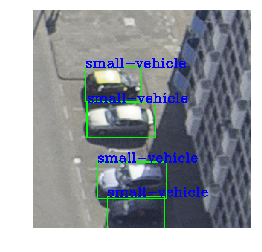

In [35]:
catIds = coco.getCatIds(catNms=['small-vehicle'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=[335328])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = io.imread('./data/trash/train/'+img['file_name'])
plt.imshow(I)
plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
print(len(annIds))
anns = coco.loadAnns(annIds)
for ann in anns:
    bbox = ann['bbox']
    x = [int(x) for x in bbox]
    cv2.rectangle(I, (x[0],x[1]), (x[0]+x[2],x[1]+x[3]), (0,255,0), 2)
    cv2.putText(I, CLASS[ann['category_id']], (x[0],x[1]), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
plt.imshow(I)

In [16]:

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=[''])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=[335328])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = io.imread('./data/trash/{}/'.format(phase)+img['file_name'])
plt.imshow(I)
plt.axis('off')
print(img)
annIds = coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
print(len(annIds))
anns = coco.loadAnns(annIds)
for ann in anns:
    bbox = ann['bbox']
    x = [int(x) for x in bbox]
    cv2.rectangle(I, (x[0],x[1]), (x[0]+x[2],x[1]+x[3]), (0,255,0), 2)
    cv2.putText(I, CLASS[ann['category_id']], (x[0],x[1]), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
plt.imshow(I)
#coco.showAnns(anns)

[]


FileNotFoundError: [Errno 2] No such file or directory: './data/trash/train/P4544_1_23296.0_10400.0_0part946.jpg'